#  Working title: Constrained optimization of the synthetic control method with application to the Economic Costs of Organized Crime (Pinotti, 2015)
###### Jessica Cremonese, Muhammad-Danial Syed, Xue Wang

*[WRITE QUICK INTRODUCTION ON WHAT THE PROJECT IS ABOUT AND IF WHAT YOU NEED ON YOUR PC TO RUN IT]*

## Table of contents
**Update links!!**

1. [Introduction](link)<br>
2. [The Economic Costs of Organized Crime, Pinotti(2015)](link)<br>
    2.2. [Topic presentation](link)<br>
    2.3. [Tecnhiques and results of the paper by Pinotti(2015)](link)<br>
    2.4. [Something on the other replication paper?](link)<br>
3. [Synthetic control methods](link)<br>
4. [Preliminary work for replication](link)<br>
    4.1. [Figures and graphs](link)<br>
    4.2. [Data preparation](link)<br>
5. [Replication of Pinotti (2015)](link)<br>
    5.1. [Optimization methods](link)<br>
    5.2. [Synthetic control performance analysis](link)<br>
6. [MORE?]()
6. [References](link)<br>

## Introduction

Synthetic Controls are, “arguably the most important innovation in the policy evaluation literature in the last 15 years” - Athey and Imbens, 2017.


### What are they?
- Used to evaluate the effect of an intervention in comparative case studies.
- Based on the idea that a combination of unaffected units often provides a better comparison than any single unaffected unit alone.
- This combination is captured through weights calculated by optimization algorithms. 
- Similar to Diff-in-Diff method; in fact, according to Abadie et al. (2010) the synthetic control methods generalizes the Diff-in-Diff model by allowing the effect of unobserved confounders to vary over time.
- This advantage arises from a flexible factor representation of the potential outcomes of treated units.
- Wide usage: Academia, multilateral organizations, think tanks, business analytics units, governmental agencies, and consulting firms.



In [1]:
import numpy as np
import cvxpy as cvx
import pandas as pd
import scipy.optimize
import statsmodels.api as sm
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear
import statsmodels.formula.api as smf

%matplotlib inline

## Paragraph 1

## Paragraph 2

## Empirical Application: The Economic Costs of Organized Crime: Evidence From Southern Italy" (Pinotti, 2015) 


### Background 

## Pre-analysis Figures and Graphs

In [2]:
# Import dataset
dtafile = 'dataset/Pinotti-replication/dataset.dta'

df = pd.read_stata(dtafile)
df1 = df[df['year'] >= 1983]

df2 = df1.groupby(['region', 'reg'])[['gdppercap', 'mafia', 'murd', 'ext', 'fire', 'kidnap', 'rob', 'smug',
            'drug', 'theft', 'orgcrime']].mean()

df2 = df2.reset_index()

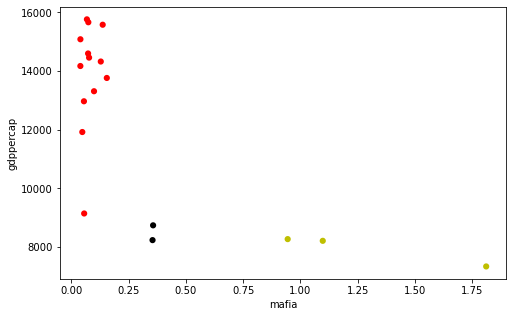

In [4]:
# Figure 1
color = np.where((df2['reg']==15) | (df2['reg']==18) | (df2['reg']==19), 'y', 
                 np.where((df2['reg']==16) | (df2['reg']==17), 'k',
                          np.where((df2['reg']<=12) | (df2['reg']==20), 'r', 'none')))

df2.plot.scatter('mafia', 'gdppercap', c=color, s=10, linewidth=3)
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

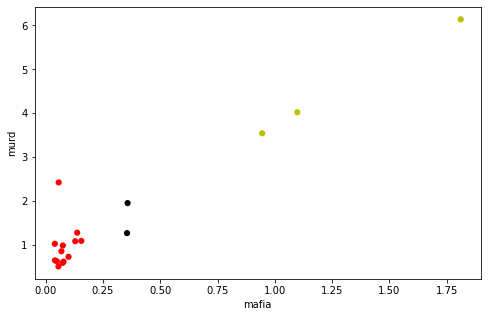

In [6]:
# Figure 3
df2.plot.scatter('mafia', 'murd', c=color, s=10, linewidth=3)
plt.rcParams["figure.figsize"] = (8,5)
plt.show()

<AxesSubplot:xlabel='year'>

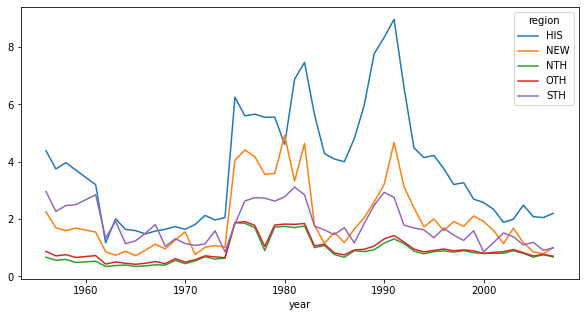

In [8]:
# Figure 4
df3 = df[df['reg'] > 20]
df3 = df3[df3['year'] >= 1956]

df3 = df3[['murd', 'year', 'region']]
df3 = df3.pivot(index='year', columns='region', values='murd')
plt.rcParams["figure.figsize"] = (10,5)
df3.plot()

## Data Preparation

In [9]:
dtafile = 'dataset/Pinotti-replication/dataset.dta'
data = pd.read_stata(dtafile)

# Specify conditions for treated unit and control units as per Pinotti's paper (c.f. F216), 

treat_unit = data[data.reg == 21]
treat_unit = treat_unit[treat_unit.year <= 1960]                 # Matching period: 1951 to 1960
treat_unit_all = data[data.reg == 21]                            # Entire period:   1951 to 2007

control_units = data[(data.reg <= 14) | (data.reg ==20)]
control_units     = control_units[control_units.year <= 1960]
control_units_all = data[(data.reg <= 14) | (data.reg ==20)]

# Extract the outcome variable for treatment and control unit, y: GDP per capita

y_treat     = np.array(treat_unit.gdppercap).reshape(1, 10)              # Matching period 
y_treat_all = np.array(treat_unit_all.gdppercap).reshape(1, 57)          # Entire period

y_control     = np.array(control_units.gdppercap).reshape(15, 10)
y_control_all = np.array(control_units_all.gdppercap).reshape(15, 57)

## Data Organization into Appropriate Format 

In [10]:
## Prepare matrices with only the relevant variables into CVXPY format, predictors k = 8

# k x 1 vector: mean values of k predictors for 1 treated unit
X1 = treat_unit[['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']]
X1 = X1.set_index(np.arange(len(X1)) // 10).mean(level=0)
X1 = X1.values               

# k x J matrix: mean values of k predictors for J untreated units
X0 = control_units[['gdppercap', 'invrate', 'shvain', 'shvaag', 'shvams', 'shvanms', 'shskill', 'density']]
X0 = X0.set_index(np.arange(len(X0)) // 10).mean(level=0)
X0 = X0.values

## Optimization with CVXPYY

$$
\hat{\boldsymbol{W}}=\operatorname{argmin}_{\boldsymbol{W}}\left[\sum_{m=1}^{k}\left(x_{m1}-\sum_{j=2}^{J+1}\boldsymbol{w}_{j} \boldsymbol{x}_{mj}\right)^{2}\right]
$$

subject to
                                                      
$$ \sum_{j=2}^{J+1}\boldsymbol{w}_{j}=1$$   

where w are the 15 weights, one for each of the control regions 'donor pool'.

Which combination of weights best resembles the pre-intervention predictors values for the treated unit?



In [11]:
# Setup the objective for CVXPY function
w = cvx.Variable((1, 15), nonneg=True)
objective_function = cvx.Minimize(cvx.sum_squares(X1 - w @ X0))
objective_constraints = [cvx.sum(w) == 1]
objective_solution = cvx.Problem(objective_function, objective_constraints).solve(verbose=False) #set True for details


In [12]:
# CVXPY Solution
print('\nObjective Value: ',objective_solution,'\n\nOptimal Weights: ',w.value)
sol_frame = pd.DataFrame({'Region':control_units.region.unique(), 
                           'Weights': np.round(w.value[0], decimals=3)})
display(sol_frame)


Objective Value:  833.2880036755997 

Optimal Weights:  [[0.         0.         0.         0.         0.15165999 0.
  0.         0.         0.         0.         0.         0.
  0.         0.84834001 0.        ]]


,Region,Weights
0,PIE,0.000
1,VDA,0.000
2,LOM,0.000
3,TAA,0.000
4,VEN,0.152
5,FVG,0.000
6,LIG,0.000
7,EMR,0.000
8,TOS,0.000
9,UMB,0.000


#### Commentary:
- The basic CVXPY minimization problem allocates weights to VEN (Veneto: 0.152) and MOL (Molise: 0.848). 
- In comparison the weights in the paper are to ABR (Abruzzo: 0.624) and MOL (0.376).
- Becker and Klößner found the weights to ABR (43.035), MOL 48.934, and Sardinia (SDR: 8.03045). 

But what do these weights mean in terms of the actual performance of our synethic controls?

## Synthetic Control Performance Analysis

#### Table Comparison

In [15]:
# Dataframe to show predicted vs actualvalues  (RMSPE) of optimizer and Pinotti weights
w_paper = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.624, 0.376, 0]).reshape(1, 15)
data_compare = pd.DataFrame({'Actual':X1[0],
                             'Paper':(w_paper @ X0)[0],
                             'Optimizer':(w @ X0).value[0],
                             'Paper Differential': (w_paper @ X0)[0] - X1[0],
                             'Optimizer Differential': (w @ X0).value[0] - X1[0]},
                              index= data.columns[[3,16,11,12,13,14,26,28]]
)

print('RMSPE CVXPY: {} \nRMSPE Paper: {}'\
      .format(np.sqrt(np.mean((w.value @ y_control - y_treat)**2)), 
             np.sqrt(np.mean((w_paper @ y_control - y_treat)**2))))

print ('\nBreakdown across predictors:')
data_compare

RMSPE CVXPY: 154.26663518337438 
RMSPE Paper: 130.14101997364745

Breakdown across predictors:


,Actual,Paper,Optimizer,Paper Differential,Optimizer Differential
gdppercap,2394.995605,2402.903783,2398.078601,7.908178,3.082995
invrate,0.316296,0.232005,0.212794,-0.084291,-0.103502
shvain,0.215479,0.221464,0.228207,0.005985,0.012728
shvaag,0.151702,0.154425,0.167108,0.002723,0.015406
shvams,0.401665,0.391364,0.383643,-0.010302,-0.018023
shvanms,0.231154,0.232748,0.221043,0.001594,-0.010111
shskill,0.165486,0.180807,0.159343,0.015321,-0.006143
density,134.778870,105.627378,106.077449,-29.151492,-28.701421


#### Graphical Comparison

In [33]:
w_paper = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.624, 0.376, 0]).reshape(1, 15)  # weights from Pinotti

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=w.value[0] @ y_ctr_all,
                    mode='lines', name='Optimizer'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=(w_paper @ y_ctr_all)[0],
                    mode='lines', name='Pinotti'))
fig.add_trace(go.Scatter(x=list(data.year.unique()), y=y_tr_all[0],
                    mode='lines', name='Treated unit'))

fig.add_shape(dict(type="line", x0=1960, y0=0, x1=1960, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_shape(dict(type="line", x0=1974, y0=0, x1=1974, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_shape(dict(type="line", x0=1980, y0=0, x1=1980, y1=11000,
                   line=dict(color="Black", width=1)))

fig.add_trace(go.Scatter(x=[1960], y=[12000], mode="text",
    name="Matching", text=["End of Matching<br>Period"]))

fig.add_trace(go.Scatter(x=[1974], y=[12000], mode="text",
    name="Event 1", text=["Drug<br>Smuggling"]))

fig.add_trace(go.Scatter(x=[1981], y=[12000], mode="text",
    name="Event 2", text=["Basilicata<br>Earthquake"]))

fig.update_layout(title='Synthetic Control<br>Optimizer vs. Treated unit',
                   xaxis_title='Time', yaxis_title='GDP per Capita')

# Dynamic graph
fig.show()

# Static graph only for display on github
#fig.show(renderer="png")     

Our obtained weights $$w$$ can not be optimal since there exists weights $$w^{*}$$ such that $$RMSPE(w) > RMSPE(w^{*})$$

Clearly, there is room for improvement in the optimizatio algorithm. We proceed by augmenting the objective function with the relative importance of each of the k predictors

## References
- Pinotti, Paolo. "The economic consequences of organized crime: Evidence from Southern Italy." Bank of Italy (2011).
- Becker, Martin, and Stefan Klößner. "Estimating the economic costs of organized crime by synthetic control methods." Journal of Applied Econometrics 32.7 (2017): 1367-1369.
- Blackburn, Keith, Kyriakos C. Neanidis, and Maria Paola Rana. "A theory of organized crime, corruption and economic growth." Economic Theory Bulletin 5.2 (2017): 227-245.
- Garoupa, Nuno. "The economics of organized crime and optimal law enforcement." Economic Inquiry 38.2 (2000): 278-288.